In [7]:
import psycopg2
import pandas as pd
import numpy as np
import re
import os

# scaling 
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler, SequentialSampler
from torch.cuda.amp import GradScaler, autocast

# model 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightgbm as lgb
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

# wandb
import wandb

# evaluation
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, average_precision_score, accuracy_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc as calculate_auc  
from sklearn.model_selection import StratifiedKFold

/home/mdhi/anaconda3/envs/pytorchgan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ykjeong-info. Use `wandb login --relogin` to force relogin


True

## 데이터 추출
필요할 경우, parquet 포맷으로 추출 

In [3]:
# PostgreSQL 서버 연결 정보

host = '192.168.0.76'  # 호스트 주소
database = 'mimiciv-2.2'  # 데이터베이스 이름
user = 'ykjeong'  # 사용자 이름
password = 'mdhi1234!'  # 비밀번호

# PostgreSQL 서버에 연결
conn = psycopg2.connect(
    dbname=database,
    user=user,
    password=password,
    host=host
)

### 환자 정보

In [31]:
# patients: 18세 이하 제외

query = '''
SELECT 
  icu.stay_id,
  icu.hadm_id,
  pa.anchor_age + EXTRACT(EPOCH FROM icu.intime - TO_TIMESTAMP(TO_CHAR(pa.anchor_year, '0000') || '0101' || '000000', 'yyyymmddHH24MISS')) / 31556908.8 AS age,
  ad.race,
  pa.gender,
  icu.last_careunit,
  icu.intime,
  ad.deathtime,
  ad.dischtime,
  ad.hospital_expire_flag
FROM mimiciv_hosp.admissions AS ad
INNER JOIN mimiciv_hosp.patients AS pa
  ON ad.subject_id = pa.subject_id
INNER JOIN mimiciv_icu.icustays AS icu
  ON ad.hadm_id = icu.hadm_id
WHERE (pa.anchor_age + EXTRACT(EPOCH FROM icu.intime - TO_TIMESTAMP(TO_CHAR(pa.anchor_year, '0000') || '0101' || '000000', 'yyyymmddHH24MISS')) / 31556908.8) >= 19;
'''
patients = pd.read_sql_query(query, conn)

/tmp/ipykernel_955090/2567657599.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  patients = pd.read_sql_query(query, conn)


In [39]:
# pos / neg 비율 확인

patients['hospital_expire_flag'].value_counts(normalize=True)

hospital_expire_flag
0    0.886069
1    0.113931
Name: proportion, dtype: float64

In [ ]:
# 컬럼명 변경
patients.rename(columns={
    'hospital_expire_flag':'dead_in_hosp', 
    'last_careunit':'CU type',
    'deathtime':'death or dischtime'
}, inplace=True)

# 'deathtime' 컬럼이 NaT인 경우 'dischtime' 값으로 채우고 'dischtime' 컬럼은 삭제
patients['death or dischtime'] = patients['death or dischtime'].fillna(patients['dischtime'])
patients.drop(columns=['dischtime'], inplace=True)

# ICU 유형 간략화하고 Care Unit이 아닌 데이터 삭제 
patients = patients[patients['CU type'].str.contains('CU')]

def categorize_careunit(careunit):
    if 'MICU' in careunit:
        return 'MICU'
    elif 'SICU' in careunit:
        return 'SICU'
    elif 'Neuro SICU' in careunit:
        return 'Neuro SICU'
    elif 'CCU' in careunit:
        return 'CCU'
    elif 'TSICU' in careunit:
        return 'TSICU'
    elif 'CVICU' in careunit:
        return 'CVICU'
    else:
        return 'other'

patients['CU type'] = patients['CU type'].apply(categorize_careunit)


# 인종 구분 변경: race 값을 간략화
def categorize_race(race):
    if 'WHITE' in race.upper():
        return 'white'
    elif 'BLACK' in race.upper():
        return 'black'
    elif 'HISPANIC' in race.upper() or 'LATINO' in race.upper():
        return 'hispanic/latino'
    elif 'ASIAN' in race.upper():
        return 'asian'
    else:
        return 'other'

patients['race'] = patients['race'].apply(categorize_race)

### item label 

In [ ]:
# icu chart item id 추출 
query = '''
SELECT dt.itemid, dt.label
FROM mimiciv_icu.d_items AS dt
WHERE dt.linksto = 'chartevents';
'''
icu_itemid = pd.read_sql_query(query, conn)

# labevent id 추출 

query = '''
SELECT *
FROM mimiciv_hosp.d_labitems AS dt;
'''
lab_itemid = pd.read_sql_query(query, conn)

In [ ]:
itemid = pd.concat([icu_itemid, lab_itemid])
itemid.sort_values(by='label', inplace=True)

# itemid에서 label 컬럼 값이 결측치인 행 삭제 
itemid.dropna(subset=['label'], inplace=True)

# 특수기호 삭제
def remove(text):
    if isinstance(text, str):
        return re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text

for col in itemid.columns:
    if itemid[col].dtype == object:
        itemid[col] = itemid[col].apply(remove)

itemid.sort_values(by='label', inplace=True)

### chart event 

In [ ]:
# chartevents 추출 
query = '''
SELECT ce.stay_id, 
       ce.hadm_id,
       ce.charttime,
       ce.itemid,
       ce.valuenum,
       ce.valueuom
FROM mimiciv_icu.chartevents AS ce
JOIN mimiciv_icu.icustays AS icu
ON ce.stay_id = icu.stay_id
AND ce.itemid IN (
    220210, -- respiratory rate
    220045, -- heart rate
    220179, 220180, -- nisbp, nidbp /  mmHg
    223761, 223762, -- temperature
    220739, 223901, 223900, 226756, 227011, 226757, 227012, 226758, 228112, 227014, -- gcs 
    225624, -- blood urea nitrogen
    227444, -- crp
    220602, -- chloride
    220615, -- creatinine
    220621, -- glucose
    220228, -- hemoglobin
    227457, -- platelet
    227465, -- prothrombin time 	 	   
    220644, 220587, -- ALT, AST
    220546 -- wbc
);
'''
chartevents = pd.read_sql_query(query, conn)

In [ ]:
# labevent 추출 

query = '''
SELECT le.hadm_id,
       le.itemid,
       le.charttime,
       le.valuenum,
       le.valueuom
FROM mimiciv_hosp.labevents AS le
JOIN mimiciv_icu.icustays AS icu
ON le.hadm_id = icu.hadm_id 
AND le.itemid IN (
    50817, -- SpO2
    52703, 51069, -- albumin (urine), g/dL
    51464, 51966, -- Bilirubin (urine), mg/dL
    52647, 51006, -- blood urea nitrogen, mg/dL
    50902, 52535, -- chloride 
    51082, 51106,-- creatinine (urine) 
    51084, 51478, -- glucose (urine)
    50811, 51222, 51640, -- hemoglobin (Blood, Chemistry)
    51704, 51265, -- platelet
    52046, 51097, -- potassium(urine)
    52047, 51100, -- sodium(urine)
    50861, 53084, 50878, 53088, -- ALT, AST 
    51300, 51301 -- wbc
);
'''
labevents = pd.read_sql_query(query, conn)

In [ ]:
events = pd.concat([labevents, chartevents])
events.sort_values(by='hadm_id', inplace=True)

## 데이터 클렌징

In [ ]:
# itemid와 events 데이터프레임을 merge

events_df = pd.merge(events, itemid, on='itemid', how='inner')
events_df = events_df[['stay_id', 'hadm_id', 'label', 'charttime', 'valuenum','valueuom']]
events_df.sort_values(by=['hadm_id', 'charttime'], inplace=True, ascending=False)
events_df.head()

In [ ]:
# stay_id가 결측치인 행/아닌 행을 분리해서 stay_id 처리

missing_stay_id = events_df[events_df['stay_id'].isna()]
df_1 = pd.merge(missing_stay_id, patients, on='hadm_id', how='inner')
df_1.drop(columns='stay_id_x', inplace=True)
df_1.rename(columns={'stay_id_y':'stay_id'}, inplace=True)

filled_stay_id = events_df[~events_df['stay_id'].isna()]
df_2 = pd.merge(filled_stay_id, patients, on='stay_id', how='inner')
df_2.drop(columns='hadm_id_x', inplace=True)
df_2.rename(columns={'hadm_id_y':'hadm_id'}, inplace=True)

df = pd.concat([df_1, df_2])

In [ ]:
# downcast: 데이터 타입 최적화
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='float')
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='integer')    

In [ ]:
# 컬럼 순서 정리, 데이터 오름차순으로 정렬 

df = df[['stay_id','hadm_id','age','race','gender','CU type','intime','charttime','label','valuenum','valueuom','death or dischtime','dead_in_hosp']]
df.sort_values(by=['stay_id', 'charttime'], ascending=True, inplace=True)

In [ ]:
# los 계산 (charttime - intime)
df['los'] = (df['charttime'] - df['intime']).dt.total_seconds() / (60 * 60 * 24)  # 일 단위로 변환

# 체류 시각이 0보다 작은 행 삭제
df = df[(df['los'] >= 0)]

# df에서 'charttime'의 값이 'intime' 이전이거나 'death or dischtime' 이후인 행 삭제 
df = df[(df['charttime'] >= df['intime']) | (df['charttime'] <= df['death or dischtime'])]

In [ ]:
# los 값의 최댓값이 60 이상인 stay_id를 가진 행을 데이터프레임에서 삭제

max_los_per_stay_id = df.groupby('stay_id')['los'].max()

stay_ids_to_remove = max_los_per_stay_id[max_los_per_stay_id >= 60].index
df_filtered = df[~df['stay_id'].isin(stay_ids_to_remove)]
df_filtered.sort_values(by=['stay_id', 'charttime'], ascending=True, inplace=True)
df_filtered = df_filtered[['stay_id', 'age', 'race', 'gender', 'CU type', 'los', 'intime','charttime', 'label', 'valuenum', 'valueuom','death or dischtime','dead_in_hosp']]

In [ ]:
# 'dead_in_hosp' 값(0/1)의 비율 확인
df_filtered['dead_in_hosp'].value_counts(normalize=True)

### - item label, 단위 통일 

In [ ]:
# Item label 간략하게 수정

replacements = {
    '  ': ' ',
    ' Count': '',
    ' serum': '',
    ' Celsius': '',
    'Urine ': '',
    ' Urine': '',
    'Alanine Aminotransferase ALT': 'ALT',
    'Asparate Aminotransferase AST': 'AST',
    'Non Invasive Blood Pressure diastolic': 'dbp',
    'Non Invasive Blood Pressure systolic': 'sbp',
    'Urea Nitrogen': 'BUN',
    'CReactive Protein': 'CRP',
    'C Reactive Protein CRP': 'CRP',
    'GCSMotorApacheIIValue': 'GCS Motor Response',
    'GCSVerbalApacheIIValue': 'GCS Verbal Response',
    'GCSEyeApacheIIValue': 'GCS Eye Opening',
    'Oxygen Saturation': 'SpO2',
    'White Blood Cells': 'WBC',
    'wbc': 'WBC'
}

df_filtered['label'] = df_filtered['label'].replace(replacements, regex=True)

In [ ]:
# 온도 단위 통일: 화씨 온도를 섭씨 온도로 변환

fahrenheit_mask = df_filtered['label'] == 'Temperature Fahrenheit'
df_filtered.loc[fahrenheit_mask, 'valuenum'] = (df_filtered.loc[fahrenheit_mask, 'valuenum'] - 32) * 5.0 / 9.0

# label 수정
df_filtered.loc[fahrenheit_mask, 'label'] = 'Temperature'
df_filtered.loc[fahrenheit_mask, 'valueuom'] = '°C'
c_mask = df_filtered['label'] == 'Temperature'
df_filtered.loc[c_mask, 'label'] = 'Temperature'
df_filtered.loc[c_mask, 'valueuom'] = '°C'

# 'wbc'의 단위가 '#/hpf'인 행 삭제, 단위 컬럼 삭제 
df_filtered = df_filtered[df_filtered['valueuom'] != '#/hpf']
df_filtered.drop(columns='valueuom', inplace=True)

### - 중복 제거 및 outlier 처리 

In [ ]:
# vital sign 이상치 조정 

# 기준 설정
ranges = {
    'Respiratory Rate': (5, 50),
    'Heart Rate': (10, 190),
    'sbp': (40, 230),
    'dbp': (20, 130),
    'Temperature': (32, 41), 
    'SpO2': (68, 100),    
    'GCS Eye Opening':(1, 4),
    'GCS Verbal Response':(1, 5),
    'GCS Motor Response':(1, 6),
        
    'ALT':(0, 5000), 
    'AST':(0, 10000), 
    'Albumin':(0, 5.5), 
    'BUN':(0, 150), 
    'Bilirubin':(0, 50),
    'CRP':(0, 300), 
    'Chloride':(70, 135),
    'Creatinine':(0, 15),
    'Glucose':(0, 600),
    'Hemoglobin':(0, 25),
    'Potassium':(2, 9),
    'Sodium':(105, 170),
    'Platelet':(0, 1000),
    'Prothrombin time':(0, 8), 
    'WBC':(0, 90), 
}

# 범위를 벗어난 값들을 NaN으로 대체
def replace_out_of_range_with_nan(row):
    label = row['label']
    value = row['valuenum']
    
    if label in ranges:
        lower, upper = ranges[label]
        
        # 값이 범위를 벗어나면 NaN으로 대체
        if value < lower or value > upper:
            return np.nan
    return value


for label, (lower, upper) in ranges.items():
    mask = (df_filtered['label'] == label)
    df_filtered.loc[mask, 'valuenum'] = np.where(
        (df_filtered.loc[mask, 'valuenum'] < lower) | (df_filtered.loc[mask, 'valuenum'] > upper),
        np.nan,
        df_filtered.loc[mask, 'valuenum']
    )
    
# NaN 값을 각 label에 대한 평균값으로 대체
df_filtered['valuenum'] = df_filtered.groupby('label')['valuenum'].transform(lambda x: x.fillna(x.mean()))
df_filtered.head()

In [ ]:
# 중복이 있을 경우 value가 큰 값을 남김 

df_filtered = df_filtered.sort_values(by=['stay_id', 'charttime', 'label']).drop_duplicates(subset=['stay_id', 'charttime', 'label'], keep='last')

## pivoting

In [ ]:
df_chart = df_filtered.pivot_table(index=['stay_id', 'charttime'], columns='label', values='valuenum', aggfunc='first')
df_chart.reset_index(inplace=True)

# `stay_id` 및 `charttime`을 기준으로 정렬
df_chart.sort_values(by=['stay_id', 'charttime'], ascending=True, inplace=True)
df_chart.head()

## merging

In [3]:
df_chart = pd.read_parquet('/home/ykjeong/iMORS/new_repo2/df_chart.parquet')
patients = pd.read_parquet('/home/ykjeong/iMORS/new_repo2/patients.parquet')

In [4]:
df = df_chart.merge(patients, on='stay_id', how='inner')
df.drop(columns=['hadm_id'], inplace=True)
df.sort_values(by=['stay_id', 'charttime'], ascending=True, inplace=True)

In [5]:
# 'dead_in_hosp' 값(0/1)의 비율 확인
df['dead_in_hosp'].value_counts(normalize=True)

dead_in_hosp
0    0.824596
1    0.175404
Name: proportion, dtype: float64

In [6]:
# 원본 레이블 유지되는지 확인 

(set(df[df['dead_in_hosp'] == 0]['stay_id'].unique()) - set(patients[patients['dead_in_hosp'] == 0]['stay_id'].unique())), (set(df[df['dead_in_hosp'] == 1]['stay_id'].unique()) - set(patients[patients['dead_in_hosp'] == 1]['stay_id'].unique()))

(set(), set())

In [7]:
def missing_value_ratio(df):
    # 각 컬럼의 결측치 비율 계산
    missing_ratio = df.isna().mean() * 100
    
    # 결측치 비율을 오름차순으로 정렬하여 출력
    print("Missing Values Percentage in Each Column:")
    print(missing_ratio.sort_values(ascending=True))

missing_value_ratio(df)

Missing Values Percentage in Each Column:
stay_id                 0.000000
charttime               0.000000
gender                  0.000000
race                    0.000000
death or dischtime      0.000000
intime                  0.000000
dead_in_hosp            0.000000
CU type                 0.000000
age                     0.000000
Heart Rate             36.855743
Respiratory Rate       37.288699
sbp                    60.290155
dbp                    60.298869
Temperature            82.887751
GCS Eye Opening        85.100414
GCS Verbal Response    85.130207
GCS Motor Response     85.168448
Chloride               91.513409
Hemoglobin             91.777458
BUN                    91.808181
Platelet               92.393531
WBC                    92.516329
Glucose                95.288256
Creatinine             95.638385
Prothrombin time       97.409122
ALT                    97.916236
AST                    97.917433
SpO2                   98.354688
Sodium                 99.746571
P

## split and resampling(다음 순서대로)
- 범주형 원핫인코딩
- data split 
- 결측치 처리
- 1시간 간격으로 resample
- downsampling
- 정규화

### - one-hot encoding

In [8]:
# 범주형 열 목록
categorical_cols = ['race', 'gender', 'CU type']

# 범주형 변수 원핫인코딩
df_encoded = pd.get_dummies(df, columns=categorical_cols)
df_encoded['dead_in_hosp'].value_counts(normalize=True)

dead_in_hosp
0    0.824596
1    0.175404
Name: proportion, dtype: float64

In [9]:
# 레이블 유지되는지 확인 

set(df[df['dead_in_hosp'] == 0]['stay_id'].unique()) == set(df_encoded[df_encoded['dead_in_hosp'] == 0]['stay_id'].unique()), set(df[df['dead_in_hosp'] == 1]['stay_id'].unique()) == set(df_encoded[df_encoded['dead_in_hosp'] == 1]['stay_id'].unique())

(True, True)

### - train, test, valid split
무작위 stay_id를 7:2:1로 분할

In [10]:
# train, test, valid split = 7:2:1

unique_stay_ids = df_encoded['stay_id'].unique()
np.random.seed(42)
np.random.shuffle(unique_stay_ids)

train_ids = unique_stay_ids[:int(0.7 * len(unique_stay_ids))]
val_ids = unique_stay_ids[int(0.7 * len(unique_stay_ids)):]
test_ids = unique_stay_ids[int(0.9 * len(unique_stay_ids)):]

train = df_encoded[df_encoded['stay_id'].isin(train_ids)]
val = df_encoded[df_encoded['stay_id'].isin(val_ids)]
test = df_encoded[df_encoded['stay_id'].isin(test_ids)]

In [11]:
# pos/neg 비율이 데이터세트끼리 유사한지 확인 

train['dead_in_hosp'].value_counts(normalize=True), test['dead_in_hosp'].value_counts(normalize=True), val['dead_in_hosp'].value_counts(normalize=True)

(dead_in_hosp
 0    0.828358
 1    0.171642
 Name: proportion, dtype: float64,
 dead_in_hosp
 0    0.810327
 1    0.189673
 Name: proportion, dtype: float64,
 dead_in_hosp
 0    0.815783
 1    0.184217
 Name: proportion, dtype: float64)

### - 결측치 처리(1)

In [12]:
# train, val, test 각각의 dataset에 결측치 처리 

def nan_fill(df):
    
    # 1. forward fill
    df_ffill = df.groupby('stay_id').apply(lambda group: group.ffill()).reset_index(drop=True)

    # 2. median fill
    overall_median_values = df_ffill.median()
    for col in (df_ffill.columns):
        df_ffill[col] = df_ffill[col].fillna(overall_median_values[col])

    return df_ffill

train = nan_fill(train)
val = nan_fill(val)
test = nan_fill(test)

/tmp/ipykernel_1231905/4186026601.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ffill = df.groupby('stay_id').apply(lambda group: group.ffill()).reset_index(drop=True)
/tmp/ipykernel_1231905/4186026601.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ffill = df.groupby('stay_id').apply(lambda group: group.ffill()).reset_index(drop=True)
/tmp/ipykernel_1231905/4186026601.py:6: DeprecationWarni

### - 1시간 단위 리샘플링

In [13]:
# stay_id 그룹별로 문자형 데이터 결측치 처리 

def fill_na_with_group_values(df, columns_to_fill, group_col='stay_id'):
    # 1. forward fill
    df_ffill = df.groupby(group_col).apply(lambda group: group.ffill()).reset_index(drop=True)
    
    # 2. backward fill to handle remaining NaNs
    df_bfill = df_ffill.groupby(group_col).apply(lambda group: group.bfill()).reset_index(drop=True)
    
    for col in columns_to_fill:
        df[col] = df_bfill[col]

    return df

columns_to_fill = ['age', 'intime', 'death or dischtime', 'dead_in_hosp', 'race_asian',
                   'race_black', 'race_hispanic/latino', 'race_other', 'race_white',
                   'gender_F', 'gender_M', 'CU type_CCU', 'CU type_CVICU', 'CU type_MICU',
                   'CU type_SICU']

train = fill_na_with_group_values(train, columns_to_fill)
val = fill_na_with_group_values(val, columns_to_fill)
test = fill_na_with_group_values(test, columns_to_fill)

/tmp/ipykernel_1231905/2394396441.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ffill = df.groupby(group_col).apply(lambda group: group.ffill()).reset_index(drop=True)
/tmp/ipykernel_1231905/2394396441.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bfill = df_ffill.groupby(group_col).apply(lambda group: group.bfill()).reset_index(drop=True)
/tmp/ipykernel_1231905/2394396441.py:5: Deprecatio

In [14]:
# 데이터프레임을 1시간 단위로 리샘플링

def resampling(df):           
    df.set_index('charttime', inplace=True)   
     
    # 그룹별 리샘플링 함수
    def resample_group(group):
        group_resampled = group.resample('h').mean()
        group_resampled['stay_id'] = group['stay_id'].iloc[0]
        return group_resampled.reset_index()
    
    resampled = df.groupby('stay_id').apply(resample_group).reset_index(drop=True)
    resampled.sort_values(by=['stay_id', 'charttime'], ascending=True, inplace=True)
    return resampled

train = resampling(train)
val = resampling(val)
test = resampling(test)

/tmp/ipykernel_1231905/1841217022.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled = df.groupby('stay_id').apply(resample_group).reset_index(drop=True)
/tmp/ipykernel_1231905/1841217022.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled = df.groupby('stay_id').apply(resample_group).reset_index(drop=True)
/tmp/ipykernel_1231905/1841217022.py:12: DeprecationWarning: DataFrameGroupBy.

In [15]:
# 결측치 처리 

train = nan_fill(train)
val = nan_fill(val)
test = nan_fill(test)

/tmp/ipykernel_1231905/4186026601.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ffill = df.groupby('stay_id').apply(lambda group: group.ffill()).reset_index(drop=True)
/tmp/ipykernel_1231905/4186026601.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ffill = df.groupby('stay_id').apply(lambda group: group.ffill()).reset_index(drop=True)
/tmp/ipykernel_1231905/4186026601.py:6: DeprecationWarni

### - undersampling

In [16]:
# 데이터가 24개 이상인 경우만 필터링

def undersampling(df):
    undersampled = df.groupby('stay_id').filter(lambda x: len(x) >= 24)
    undersampled.sort_values(by=['stay_id', 'charttime'], ascending=False, inplace=True)    
    return undersampled

train = undersampling(train)
val = undersampling(val)
test = undersampling(test)

In [17]:
# pos/neg를 분리

neg_train = train.loc[train['dead_in_hosp'] == 0]
pos_train = train.loc[train['dead_in_hosp'] == 1]

neg_val = val.loc[val['dead_in_hosp'] == 0]
pos_val = val.loc[val['dead_in_hosp'] == 1]

neg_test = test.loc[test['dead_in_hosp'] == 0]
pos_test = test.loc[test['dead_in_hosp'] == 1]

In [18]:
# positive의 경우 각 stay_id별로 최신 시간을 기준으로 이전 24개의 행만 남김
# 이때, 사망 직전 1시간의 값이 없는 데이터를 확인해 삭제

def keep_last_24_hours(df):
    # 최신 charttime을 기준으로 정렬
    df_sorted = df.sort_values(by='charttime', ascending=False)
    df_kept = df_sorted.groupby('stay_id').head(24)
    
    # 가장 늦은 charttime 값 추출
    latest_charttime = df_kept.groupby('stay_id')['charttime'].max().reset_index()
    latest_charttime = latest_charttime.merge(df_kept[['stay_id', 'death or dischtime']].drop_duplicates(), on='stay_id')

    # 시간 차이 계산
    latest_charttime['time_difference'] = latest_charttime['death or dischtime'] - latest_charttime['charttime']

    # 1시간 초과하는 stay_id 추출
    filtered_stay_id = latest_charttime[latest_charttime['time_difference'] > pd.Timedelta(hours=1)]
    exclude_stay_ids = filtered_stay_id['stay_id'].tolist()

    # df_kept에서 해당 stay_id 값을 제외
    filtered_df_kept = df_kept[~df_kept['stay_id'].isin(exclude_stay_ids)]
    
    return filtered_df_kept

In [19]:
# negative의 경우 일부 시점을 무작위로 선택해 해당 시점 전후의 값만 사용

def keep_random_24_hours(df):
    np.random.seed(42)  # 시드 고정
    
    def select_random_window(group):
        group_sorted = group.sort_values(by='charttime', ascending=False)
        random_index = np.random.randint(0, len(group_sorted))

        start_index = max(0, random_index - 11)
        end_index = min(len(group_sorted), random_index + 12 + 1)
        selected_window = group_sorted.iloc[start_index:end_index]

        if len(selected_window) < 24:
            if start_index == 0:
                additional_rows = group_sorted.iloc[end_index:end_index + (24 - len(selected_window))]
            else:
                additional_rows = group_sorted.iloc[max(0, start_index - (24 - len(selected_window))):start_index]
            selected_window = pd.concat([selected_window, additional_rows]).drop_duplicates().head(24)

        return selected_window
    
    # 각 stay_id 그룹에 대해 select_random_window 함수를 적용
    df_kept = df.groupby('stay_id').apply(select_random_window).reset_index(drop=True)
    df_kept = df_kept.sort_values(by=['stay_id','charttime'], ascending=False)
    
    return df_kept

In [20]:
train_neg_resample = keep_random_24_hours(neg_train)
train_pos_resample = keep_last_24_hours(pos_train)
val_neg_resample = keep_random_24_hours(neg_val)
val_pos_resample = keep_last_24_hours(pos_val)
test_neg_resample = keep_random_24_hours(neg_test)
test_pos_resample = keep_last_24_hours(pos_test)

/tmp/ipykernel_1231905/640817045.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kept = df.groupby('stay_id').apply(select_random_window).reset_index(drop=True)
/tmp/ipykernel_1231905/640817045.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kept = df.groupby('stay_id').apply(select_random_window).reset_index(drop=True)
/tmp/ipykernel_1231905/640817045.py:24: DeprecationWarning: DataFrameGro

In [21]:
# negative undersampling: 무작위로 10%의 stay_id 선택

def neg_undersampling(neg_df, pos_df, num): # 0.1
    unique_stay_ids = neg_df['stay_id'].unique()
    num_to_select = int(len(unique_stay_ids) * num) 
    np.random.seed(42)
    selected_stay_ids = np.random.choice(unique_stay_ids, num_to_select, replace=False)

    # 해당 stay_id에 해당하는 값만 추출
    sampled_neg = neg_df[neg_df['stay_id'].isin(selected_stay_ids)]
    resample = pd.concat([sampled_neg, pos_df])
    resample = resample.sort_values(by=['stay_id','charttime'], ascending=True)
    return resample

train_neg_down = neg_undersampling(train_neg_resample, train_pos_resample, 0.1)
val_neg_down = neg_undersampling(val_neg_resample, val_pos_resample, 0.1)
test = pd.concat([test_neg_resample, test_pos_resample])
test = test.sort_values(by=['stay_id','charttime'], ascending=True)

train_neg_down['dead_in_hosp'].value_counts(normalize=True), val_neg_down['dead_in_hosp'].value_counts(normalize=True), test['dead_in_hosp'].value_counts(normalize=True)

(dead_in_hosp
 0.0    0.649835
 1.0    0.350165
 Name: proportion, dtype: float64,
 dead_in_hosp
 0.0    0.632207
 1.0    0.367793
 Name: proportion, dtype: float64,
 dead_in_hosp
 0.0    0.947735
 1.0    0.052265
 Name: proportion, dtype: float64)

In [22]:
# 모든 stay_id group이 1시간 간격의 데이터를 가지고 있는지 확인

def check_hourly_intervals(df):
    groups_with_problems = []

    for stay_id, group in df.groupby('stay_id'):
        group = group.sort_values('charttime')
        time_diffs = group['charttime'].diff().dropna()
        
        if not all(time_diffs == pd.Timedelta(hours=1)):
            groups_with_problems.append(stay_id)
    
    return groups_with_problems

# 확인
len(check_hourly_intervals(train_neg_down)) == 0, len(check_hourly_intervals(test)) == 0, len(check_hourly_intervals(val_neg_down)) == 0

(True, True, True)

### - 날짜 변수 삭제 

In [23]:
# datetime type 변수(intime, death/dischtime 컬럼) 일괄 삭제 
    
def datetime_remove(df):
    df_no_dates = df.drop(columns=['intime', 'death or dischtime'])
    df_no_dates = df_no_dates.sort_values(by=['stay_id', 'charttime'], ascending=True)
    return df_no_dates

train = datetime_remove(train_neg_down)
val = datetime_remove(val_neg_down)
test = datetime_remove(test)

### - X/y split , 정규화

In [13]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
val = pd.read_parquet('val.parquet')

In [14]:
y_train = train['dead_in_hosp']
y_val = val['dead_in_hosp']
y_test = test['dead_in_hosp']

X_train = train.drop(columns=['dead_in_hosp'], inplace=False)
X_val = val.drop(columns=['dead_in_hosp'], inplace=False)
X_test = test.drop(columns=['dead_in_hosp'], inplace=False)

In [15]:
train.head()

,charttime,stay_id,ALT,AST,Albumin,BUN,CRP,Chloride,Creatinine,GCS Eye Opening,...,race_black,race_hispanic/latino,race_other,race_white,gender_F,gender_M,CU type_CCU,CU type_CVICU,CU type_MICU,CU type_SICU
556,2194-05-05 07:00:00,30000646.0,22.0,19.0,2.491603,11.0,106.599998,109.0,0.5,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
557,2194-05-05 08:00:00,30000646.0,22.0,19.0,2.491603,9.0,106.599998,106.0,0.5,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
558,2194-05-05 09:00:00,30000646.0,22.0,19.0,2.491603,9.0,106.599998,106.0,0.5,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
559,2194-05-05 10:00:00,30000646.0,22.0,19.0,2.491603,9.0,106.599998,106.0,0.5,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
560,2194-05-05 11:00:00,30000646.0,22.0,19.0,2.491603,9.0,106.599998,106.0,0.5,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [16]:
def scaling(df):
    # 'charttime'을 인덱스로 설정
    df.set_index('charttime', inplace=True)
    df.drop(columns=['stay_id'], inplace=True)
    
    # 정규화
    scaler = StandardScaler() # MinMaxScaler / StandardScaler
    df_scaled = scaler.fit_transform(df)
    
    return df_scaled

X_train_scaled = scaling(X_train)
X_test_scaled = scaling(X_test)
X_val_scaled = scaling(X_val)

In [17]:
def class_ratio(df):
    # 클래스별 개수 계산
    class_counts = df.value_counts()

    # 전체 데이터 개수
    total_count = len(df)

    # 클래스별 비율 계산
    class_ratios = class_counts / total_count

    print("클래스 0의 비율:", class_ratios[0])
    print("클래스 1의 비율:", class_ratios[1])

class_ratio(y_train)
class_ratio(y_val)
class_ratio(y_test)

클래스 0의 비율: 0.6498345812293227
클래스 1의 비율: 0.35016541877067736
클래스 0의 비율: 0.6322067594433399
클래스 1의 비율: 0.36779324055666
클래스 0의 비율: 0.9477345701034606
클래스 1의 비율: 0.05226542989653942


In [18]:
# sequence length와 feature 수 확인

num_features = X_test_scaled.shape[1]
sequence_length = 24
(num_features, sequence_length)

(35, 24)

In [19]:
print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)
print(X_val_scaled.shape, y_val.shape)

(137832, 35) (137832,)
(134544, 35) (134544,)
(60360, 35) (60360,)


## 모델링

### - dataset loader 정의

In [20]:

class patient_dataset(Dataset):
    def __init__(self, data, labels, sequence_length, num_features, device):
        self.data = torch.tensor(data, dtype=torch.float32).view(-1, sequence_length, num_features)
        
        if isinstance(labels, pd.Series):
            labels = labels.to_numpy()
        
        self.labels = torch.tensor(labels, dtype=torch.float32).view(-1, sequence_length, 1)
        self.sequence_length = sequence_length
        self.device = device
        
        print("Data shape:", self.data.shape)
        print("Labels shape:", self.labels.shape)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx].to(self.device)
        y = self.labels[idx].to(self.device)
        return x, y

class PatientSampler(Sampler):
    def __init__(self, data_source, group_ids, shuffle=False):
        self.data_source = data_source
        self.group_ids = group_ids
        self.shuffle = shuffle
        self.unique_groups = np.unique(group_ids)

    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.unique_groups) 
        for group in self.unique_groups:
            group_indices = np.where(self.group_ids == group)[0]
            
            # 그룹 내 sequence끼리는 섞지 않음            
            yield from group_indices

    def __len__(self):
        return len(self.data_source)

class GroupedBatchSampler(BatchSampler):
    def __init__(self, sampler, batch_size, drop_last):
        super(GroupedBatchSampler, self).__init__(sampler, batch_size, drop_last)
        self.batch_size = batch_size
        self.drop_last = drop_last

    def __iter__(self):
        batch = []
        current_group = None
        for idx in self.sampler:
            if current_group is None:
                current_group = self.sampler.group_ids[idx]
            if self.sampler.group_ids[idx] != current_group or len(batch) == self.batch_size:
                yield batch
                batch = []
                current_group = self.sampler.group_ids[idx]
            batch.append(idx)
        if len(batch) > 0 and not self.drop_last:
            yield batch

### - LSTM
model structure

In [21]:
class lstm_model(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, 
                 feature_embedding_dim=16, lstm_layers=3, 
                 num_fc_layers=5, dropout_lstm=0.4, dropout_fc=0.5):
        super(lstm_model, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.feature_embedding_dim = feature_embedding_dim
        self.lstm_layers = lstm_layers
        self.num_fc_layers = num_fc_layers

        self.feature_fc = nn.ModuleList([nn.Linear(1, feature_embedding_dim) for _ in range(input_dim)])
        self.layer_norm = nn.LayerNorm(feature_embedding_dim * input_dim)

        self.lstm = nn.LSTM(input_size=feature_embedding_dim * input_dim, hidden_size=hidden_dim, num_layers=lstm_layers, dropout=dropout_lstm, batch_first=True)

        fc_layers = []

        for _ in range(num_fc_layers - 1):
            fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout_fc))

        self.fc = nn.Sequential(*fc_layers)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size, sequence_length, num_features = x.size()

        x_emb = []
        for i in range(num_features):
            feature = x[:, :, i].unsqueeze(-1)
            feature_emb = self.feature_fc[i](feature)
            x_emb.append(feature_emb)

        x_emb = torch.cat(x_emb, dim=2)
        x_emb = self.layer_norm(x_emb)

        lstm_out, _ = self.lstm(x_emb)
        
        # 마지막 시점의 출력을 가져옴
        last_output = lstm_out[:, -1, :]

        fc_out = self.fc(last_output)
        output = self.output(fc_out)

        return output

In [22]:
# Wandb로 하이퍼파라미터 설정

wandb.init(project="mortality", entity="ykjeong-info")
config = wandb.config
config.batch_size = 512
config.learning_rate = 0.0001
config.epochs = 50
config.weight_decay = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [23]:
X_test_scaled.shape, y_test.shape

((134544, 35), (134544,))

In [24]:

group_ids = np.repeat(np.arange( (len(X_train_scaled) // 24) // sequence_length), sequence_length)
train_dataset = patient_dataset(X_train_scaled, y_train, sequence_length=24, num_features=num_features, device=device)
train_sampler = PatientSampler(train_dataset, group_ids=group_ids, shuffle=True)
train_grouped_sampler = GroupedBatchSampler(train_sampler, batch_size=config.batch_size, drop_last=False)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_grouped_sampler)

group_ids = np.repeat(np.arange((len(X_val_scaled) // 24) // sequence_length), sequence_length)
val_dataset = patient_dataset(X_val_scaled, y_val, sequence_length=24, num_features=num_features, device=device)
val_sampler = PatientSampler(val_dataset, group_ids=group_ids, shuffle=False)
val_grouped_sampler = GroupedBatchSampler(val_sampler, batch_size=config.batch_size, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_sampler=val_grouped_sampler)

group_ids = np.repeat(np.arange((len(X_test_scaled) // 24)  // sequence_length), sequence_length)
test_dataset = patient_dataset(X_test_scaled, y_test, sequence_length=24, num_features=num_features, device=device)
test_sampler = PatientSampler(test_dataset, group_ids=group_ids, shuffle=False)
test_grouped_sampler = GroupedBatchSampler(test_sampler, batch_size=config.batch_size, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_sampler=test_grouped_sampler)

Data shape: torch.Size([5743, 24, 35])
Labels shape: torch.Size([5743, 24, 1])
Data shape: torch.Size([2515, 24, 35])
Labels shape: torch.Size([2515, 24, 1])
Data shape: torch.Size([5606, 24, 35])
Labels shape: torch.Size([5606, 24, 1])


In [25]:
test_sampler

#### model training loop

In [26]:
# 모델 생성 시 input_dim을 num_features로 전달

model = lstm_model(input_dim=num_features).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

# ReduceLROnPlateau 사용
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [27]:
# Training loop

early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0
best_model_weights = model.state_dict()

for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)  # outputs: (batch_size, sequence_length, 1)

        # 마지막 시점의 출력만 사용
        outputs = outputs
        y_batch = y_batch[:, -1].view(-1, 1)  # (batch_size, 1)
        
        # 손실 계산
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    # 평균 Train Loss 계산
    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch [{epoch+1}/{config.epochs}], Train Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            
            # 마지막 시점의 출력과 타겟을 사용함
            outputs = outputs
            y_batch = y_batch[:, -1].view(-1, 1)  # (batch_size, 1)
            
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            all_labels.extend(y_batch.cpu().numpy().flatten())
            all_predictions.extend(torch.sigmoid(outputs).cpu().numpy().flatten())

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = 100 * correct / total
    val_auc = roc_auc_score(all_labels, all_predictions)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUC: {val_auc:.4f}")

    # 메트릭 로깅
    wandb.log({"epoch": epoch, "train_loss": epoch_loss, "val_loss": val_loss, "val_accuracy": val_accuracy, "val_auc": val_auc})

    # 학습률 감소 스케줄러 업데이트 및 로깅
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    wandb.log({"learning_rate": current_lr})

    # 조기 종료 검사 및 모델 가중치 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        best_model_weights = model.state_dict()
        
        torch.save(best_model_weights, "best_model.pth")
        wandb.save("best_model.pth")
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
        break
    
print("Training completed")
model.load_state_dict(best_model_weights)
wandb.finish()

Epoch [1/50], Train Loss: 0.6861
Validation Loss: 0.6369, Validation Accuracy: 63.18%, Validation AUC: 0.9518
Epoch [2/50], Train Loss: 0.5207
Validation Loss: 0.3957, Validation Accuracy: 63.18%, Validation AUC: 0.9670
Epoch [3/50], Train Loss: 0.4131
Validation Loss: 0.3702, Validation Accuracy: 91.55%, Validation AUC: 0.9701
Epoch [4/50], Train Loss: 0.3857
Validation Loss: 0.3509, Validation Accuracy: 92.07%, Validation AUC: 0.9716
Epoch [5/50], Train Loss: 0.3502
Validation Loss: 0.3391, Validation Accuracy: 92.83%, Validation AUC: 0.9690
Epoch [6/50], Train Loss: 0.3335
Validation Loss: 0.3116, Validation Accuracy: 92.63%, Validation AUC: 0.9712
Epoch [7/50], Train Loss: 0.3050
Validation Loss: 0.3310, Validation Accuracy: 92.59%, Validation AUC: 0.9734
Epoch [8/50], Train Loss: 0.2850
Validation Loss: 0.3062, Validation Accuracy: 92.51%, Validation AUC: 0.9735
Epoch [9/50], Train Loss: 0.2737
Validation Loss: 0.2647, Validation Accuracy: 92.75%, Validation AUC: 0.9733
Epoch [10/

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
learning_rate,███████████████▁▁▁
train_loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁████████████████
val_auc,▁▆▆▇▆▇▇▇▇██▇██████
val_loss,█▄▃▃▃▂▃▂▁▁▁▁▁▁▁▁▂▁
epoch,17
learning_rate,5e-05
train_loss,0.21613
val_accuracy,92.50801
val_auc,0.97502


#### evaluation

In [28]:
def calculate_metrics(dataloader, model, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)

            # outputs가 2차원인지 3차원인지 확인
            if outputs.dim() == 3:
                outputs = outputs[:, -1, :]  # 3차원일 경우, 마지막 시점의 예측값 사용
            elif outputs.dim() == 2:
                outputs = outputs  # 2차원일 경우 그대로 사용

            # y_batch의 마지막 시점 값만 사용
            y_batch = y_batch[:, -1].view(-1)

            all_labels.extend(y_batch.cpu().numpy().flatten())
            all_probs.extend(torch.sigmoid(outputs).cpu().numpy().flatten())

    # AUROC, AUPRC 및 Accuracy 계산
    try:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
        
        # Accuracy 계산(threshold 0.5)
        predictions = (np.array(all_probs) >= 0.5).astype(int)
        accuracy = accuracy_score(all_labels, predictions)
    except ValueError as e:
        print(f"Error calculating metrics: {e}")
        auroc = auprc = accuracy = None

    return auroc, auprc, accuracy


# 모델을 device로 이동
model.to(device)

# Train, Valid, Test 데이터셋에 대한 AUROC, AUPRC 및 Accuracy 계산
train_auroc, train_auprc, train_accuracy = calculate_metrics(train_dataloader, model, device)
val_auroc, val_auprc, val_accuracy = calculate_metrics(val_dataloader, model, device)
test_auroc, test_auprc, test_accuracy = calculate_metrics(test_dataloader, model, device)

# 결과 출력
print(f"Train AUROC: {train_auroc:.4f}, Train AUPRC: {train_auprc:.4f}, Train Accuracy: {train_accuracy:.4f}" if train_auroc is not None else "Error calculating Train metrics.")
print(f"Valid AUROC: {val_auroc:.4f}, Valid AUPRC: {val_auprc:.4f}, Valid Accuracy: {val_accuracy:.4f}" if val_auroc is not None else "Error calculating Valid metrics.")
print(f"Test AUROC: {test_auroc:.4f}, Test AUPRC: {test_auprc:.4f}, Test Accuracy: {test_accuracy:.4f}" if test_auroc is not None else "Error calculating Test metrics.")

Train AUROC: 0.9832, Train AUPRC: 0.9644, Train Accuracy: 0.9550
Valid AUROC: 0.9750, Valid AUPRC: 0.9575, Valid Accuracy: 0.9251
Test AUROC: 0.9757, Test AUPRC: 0.7008, Test Accuracy: 0.8289


### - LightGBM
model structure

In [29]:
# 데이터 처리 함수 정의

def process_data(dataloader):
    features_list = []
    labels_list = []
    
    for features, labels in dataloader:
        features_list.append(features.view(features.size(0), -1).cpu())  # (batch_size, sequence_length * num_features)
        labels_list.append(labels[:, -1].cpu())  # 시퀀스의 마지막 레이블만 사용
    
    X = np.concatenate(features_list, axis=0)
    y = np.concatenate(labels_list, axis=0).ravel()  # Flatten to 1D array
    
    return X, y

# data 처리
X_train, y_train = process_data(train_dataloader)
X_valid, y_valid = process_data(val_dataloader)
X_test, y_test = process_data(test_dataloader)

In [30]:
# Early stopping / Pruning callback

def get_callbacks(trial):
    early_stopping_callback = lgb.early_stopping(stopping_rounds=5, verbose=False)
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "binary_logloss")
    return [early_stopping_callback, pruning_callback]

columns_to_remove = ['charttime', 'stay_id', 'dead_in_hosp']
base_feature_names = [col for col in train.columns.tolist() if col not in columns_to_remove]

# 시퀀스 길이 설정(24)
sequence_length = X_train.shape[1] // len(base_feature_names)

# 시퀀스 각 시점에 대해 고유한 피처 이름 생성
feature_names = []
for t in range(sequence_length):
    feature_names.extend([f"{name}_t{t}" for name in base_feature_names])
    
# lgb.Dataset 생성 시 feature_name 전달
lgb_train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_data = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train_data, feature_name=feature_names)

#### model training loop

In [34]:
def objective(trial):
    # 하이퍼파라미터 공간 정의
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.7),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 5.0, 15.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 5.0, 15.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'feature_pre_filter': False, 
        'verbose': -1
    }

    # 모델 학습
    model = lgb.train(params, 
                      lgb_train_data, 
                      num_boost_round=1000,
                      valid_sets=[lgb_valid_data],
                      callbacks=get_callbacks(trial))

    preds = model.predict(X_valid)
    logloss = log_loss(y_valid, preds)
    return logloss

# Optuna Study 시작
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적 파라미터로 모델 재학습
best_params = study.best_params
best_lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': best_params['num_leaves'],
    'learning_rate': best_params['learning_rate'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'lambda_l1': best_params['lambda_l1'], 
    'lambda_l2': best_params['lambda_l2'], 
    'min_data_in_leaf': best_params['min_data_in_leaf'], 
    'max_depth': best_params['max_depth'], 
    'verbose': -1
}

# 최적 파라미터로 모델 학습
best_lgb_model = lgb.train(best_lgb_params, 
                           lgb_train_data, 
                           num_boost_round=1000,
                           valid_sets=[lgb_valid_data],
                           callbacks=[lgb.early_stopping(stopping_rounds=5, verbose=False)])

# 결과 평가 함수 정의
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    train_preds_proba = model.predict(X_train)
    valid_preds_proba = model.predict(X_valid)
    
    train_logloss = log_loss(y_train, train_preds_proba)
    valid_logloss = log_loss(y_valid, valid_preds_proba)
    
    print("Train Logloss:", train_logloss)
    print("Valid Logloss:", valid_logloss)

# 평가 수행
evaluate_model(best_lgb_model, X_train, y_train, X_valid, y_valid)

Train Logloss: 0.1221913196767412
Valid Logloss: 0.14940131217473426


#### evaluation

Top 10 features by importance:
Heart_Rate_t23: 412
sbp_t23: 329
WBC_t23: 303
GCS_Motor_Response_t23: 242
Heart_Rate_t21: 229
Heart_Rate_t20: 202
age_t0: 172
Heart_Rate_t22: 161
GCS_Eye_Opening_t23: 157
GCS_Verbal_Response_t23: 146


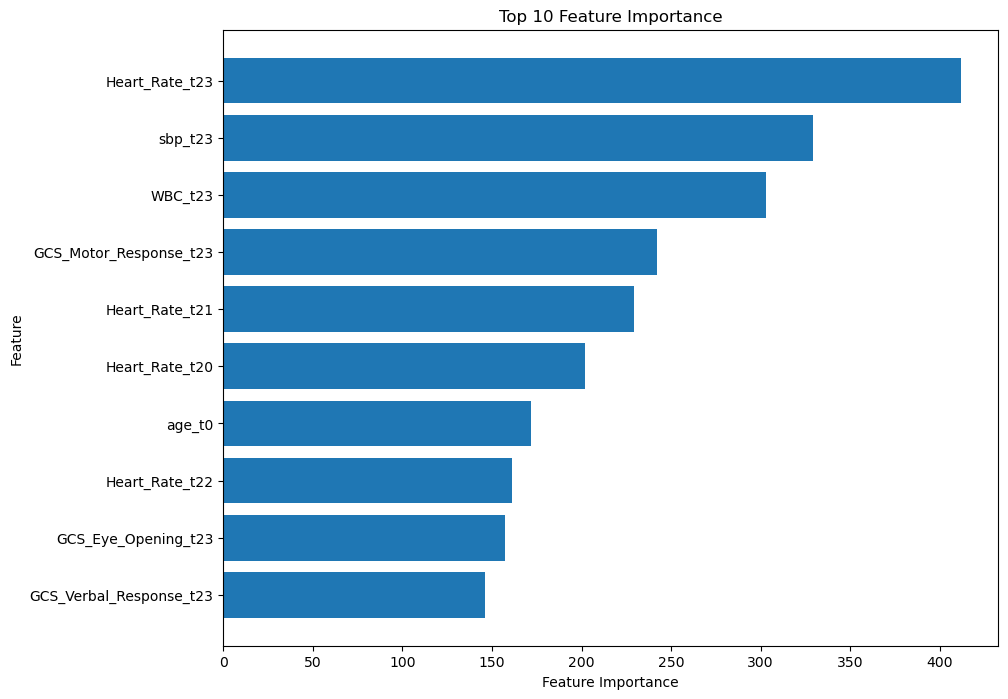

In [35]:

# 피처 중요도 계산
importance = best_lgb_model.feature_importance(importance_type='split')
feature_names = best_lgb_model.feature_name() 

# 피처 중요도 순으로 정렬
sorted_idx = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# 상위 10개 피처 확인
print("Top 10 features by importance:")
for i in range(10):
    print(f"{sorted_features[i]}: {sorted_importance[i]}")

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(sorted_features[:10], sorted_importance[:10])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [36]:

# Trainset AUROC, AUPRC 및 Accuracy 계산
train_preds_proba = best_lgb_model.predict(X_train)
train_preds = (train_preds_proba >= 0.5).astype(int)
train_auroc = roc_auc_score(y_train, train_preds_proba)
train_precision, train_recall, _ = precision_recall_curve(y_train, train_preds_proba)
train_auprc = calculate_auc(train_recall, train_precision)
train_accuracy = accuracy_score(y_train, train_preds)

print(f"Trainset AUROC: {train_auroc:.4f}")
print(f"Trainset AUPRC: {train_auprc:.4f}")
print(f"Trainset Accuracy: {train_accuracy:.4f}")

# Validset AUROC, AUPRC 및 Accuracy 계산
valid_preds_proba = best_lgb_model.predict(X_valid)
valid_preds = (valid_preds_proba >= 0.5).astype(int)
valid_auroc = roc_auc_score(y_valid, valid_preds_proba)
valid_precision, valid_recall, _ = precision_recall_curve(y_valid, valid_preds_proba)
valid_auprc = calculate_auc(valid_recall, valid_precision)
valid_accuracy = accuracy_score(y_valid, valid_preds)

print(f"Validset AUROC: {valid_auroc:.4f}")
print(f"Validset AUPRC: {valid_auprc:.4f}")
print(f"Validset Accuracy: {valid_accuracy:.4f}")

# Testset AUROC, AUPRC 및 Accuracy 계산
test_preds_proba = best_lgb_model.predict(X_test)
test_preds = (test_preds_proba >= 0.5).astype(int)
test_auroc = roc_auc_score(y_test, test_preds_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, test_preds_proba)
test_auprc = calculate_auc(test_recall, test_precision)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Testset AUROC: {test_auroc:.4f}")
print(f"Testset AUPRC: {test_auprc:.4f}")
print(f"Testset Accuracy: {test_accuracy:.4f}")


Trainset AUROC: 0.9915
Trainset AUPRC: 0.9855
Trainset Accuracy: 0.9587
Validset AUROC: 0.9858
Validset AUPRC: 0.9792
Validset Accuracy: 0.9463
Testset AUROC: 0.9849
Testset AUPRC: 0.8501
Testset Accuracy: 0.8834


### ensemble evaluation

In [37]:
model.eval()
lstm_predictions = []

# LSTM 예측
with torch.no_grad():
    for X_batch, _ in test_dataloader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        lstm_predictions.extend(outputs.squeeze().cpu().numpy())

lstm_predictions = np.array(lstm_predictions)
lgb_predictions = best_lgb_model.predict(X_test)

# Soft Voting 앙상블
ensemble_predictions = (lstm_predictions + lgb_predictions) / 2

# Threshold 적용 (0.5 이상을 1로, 0.5 미만을 0으로)
final_predictions = (ensemble_predictions >= 0.5).astype(int)

# 정확도 및 로그 손실 계산
test_labels = np.array(y_test)  
accuracy = accuracy_score(test_labels, final_predictions)
logloss = log_loss(test_labels, ensemble_predictions)
auc = roc_auc_score(test_labels, ensemble_predictions)
auprc = average_precision_score(test_labels, ensemble_predictions)

print(f"Ensemble Test accuracy: {accuracy:.4f}")
print(f'Ensemble Test AUROC: {auc:.4f}')
print(f'Ensemble Test AUPRC: {auprc:.4f}')

Ensemble Test accuracy: 0.8362
Ensemble Test AUROC: 0.9823
Ensemble Test AUPRC: 0.8065


## 외부 검증: eICU dataset

In [87]:
val = pd.read_parquet('eICU_valid_dataset.parquet')
X_val = val.drop(columns=['dead in hosp'], inplace=False)
y_val = val['dead in hosp']

In [88]:
X_val_scaled = scaling(X_val)

In [89]:
X_val_scaled.shape, y_val.shape

((643176, 35), (643176,))

In [90]:
group_ids = np.repeat(np.arange((len(X_val_scaled) // 24) // sequence_length), sequence_length)
val_dataset = patient_dataset(X_val_scaled, y_val, sequence_length=24, num_features=num_features, device=device)
val_sampler = PatientSampler(val_dataset, group_ids=group_ids, shuffle=False)
grouped_sampler = GroupedBatchSampler(val_sampler, batch_size=config.batch_size, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_sampler=grouped_sampler)

Data shape: torch.Size([26799, 24, 35])
Labels shape: torch.Size([26799, 24, 1])


In [91]:
def class_ratio(df):
    # 클래스별 개수 계산
    class_counts = df.value_counts()

    # 전체 데이터 개수
    total_count = len(df)

    # 클래스별 비율 계산
    class_ratios = class_counts / total_count

    print("클래스 0의 비율:", class_ratios[0])
    print("클래스 1의 비율:", class_ratios[1])

class_ratio(y_val)

클래스 0의 비율: 0.9117131236240158
클래스 1의 비율: 0.08828687637598417


### LSTM

In [92]:
# 최적 가중치로 validation set을 검증

def calculate_metrics(dataloader, model, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)

            # outputs가 2차원인지 3차원인지 확인
            if outputs.dim() == 3:
                outputs = outputs[:, -1, :]  # 3차원일 경우, 마지막 시점의 예측값 사용
            elif outputs.dim() == 2:
                outputs = outputs  # 2차원일 경우 그대로 사용

            # y_batch의 마지막 시점 값만 사용
            y_batch = y_batch[:, -1].view(-1)

            all_labels.extend(y_batch.cpu().numpy().flatten())
            all_probs.extend(torch.sigmoid(outputs).cpu().numpy().flatten())

    # all_labels와 all_probs의 길이 일치 여부 확인
    if len(all_labels) != len(all_probs):
        print(f"Error: Inconsistent number of samples. Labels: {len(all_labels)}, Predictions: {len(all_probs)}")
        return None, None, None

    # AUROC, AUPRC 및 Accuracy 계산
    try:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
        # Accuracy 계산: 임계값 0.5로 이진화
        predictions = (np.array(all_probs) >= 0.5).astype(int)
        accuracy = accuracy_score(all_labels, predictions)
    except ValueError as e:
        print(f"Error calculating metrics: {e}")
        auroc = auprc = accuracy = None

    return auroc, auprc, accuracy

# 모델을 로드하고 device로 이동
model_path = 'best_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Valid 데이터셋에 대한 AUROC, AUPRC 및 Accuracy 계산

val_auroc, val_auprc, val_accuracy = calculate_metrics(val_dataloader, model, device)
# 결과 출력
if val_auroc is not None:
    print(f"Valid AUROC: {val_auroc:.4f}, Valid AUPRC: {val_auprc:.4f}, Valid Accuracy: {val_accuracy:.4f}")
else:
    print("Error calculating Valid metrics.")

Valid AUROC: 0.4589, Valid AUPRC: 0.0771, Valid Accuracy: 0.6627


### LightGBM

In [93]:
# data 처리
X_valid, y_valid = process_data(val_dataloader)

# Validset AUROC, AUPRC 및 Accuracy 계산
valid_preds_proba = best_lgb_model.predict(X_valid)
valid_preds = (valid_preds_proba >= 0.5).astype(int)
valid_auroc = roc_auc_score(y_valid, valid_preds_proba)
valid_precision, valid_recall, _ = precision_recall_curve(y_valid, valid_preds_proba)
valid_auprc = calculate_auc(valid_recall, valid_precision)
valid_accuracy = accuracy_score(y_valid, valid_preds)

print(f"Validset AUROC: {valid_auroc:.4f}")
print(f"Validset AUPRC: {valid_auprc:.4f}")
print(f"Validset Accuracy: {valid_accuracy:.4f}")

Validset AUROC: 0.4023
Validset AUPRC: 0.0722
Validset Accuracy: 0.7292


### Ensemble

In [94]:
model.eval()
lstm_predictions = []

# LSTM 예측
with torch.no_grad():
    for X_batch, _ in val_dataloader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        lstm_predictions.extend(outputs.squeeze().cpu().numpy())

lstm_predictions = np.array(lstm_predictions)
lgb_predictions = best_lgb_model.predict(X_valid)

# Soft Voting 앙상블
ensemble_predictions = (lstm_predictions + lgb_predictions) / 2

# Threshold 적용 (0.5 이상을 1로, 0.5 미만을 0으로)
final_predictions = (ensemble_predictions >= 0.5).astype(int)

# 정확도 및 로그 손실 계산
valid_labels = np.array(y_valid)  
accuracy = accuracy_score(valid_labels, final_predictions)
logloss = log_loss(valid_labels, ensemble_predictions)
auc = roc_auc_score(valid_labels, ensemble_predictions)
auprc = average_precision_score(valid_labels, ensemble_predictions)

print(f"Ensemble Test Accuracy: {accuracy:.4f}")
print(f'Ensemble Test AUROC: {auc:.4f}')
print(f'Ensemble Test AUPRC: {auprc:.4f}')

Ensemble Test Accuracy: 0.6718
Ensemble Test AUROC: 0.4578
Ensemble Test AUPRC: 0.0770
